In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn,optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from generic_data import GenericDataset
from SimpleNNs import TwoNetBC

In [2]:
# seed = 0
# np.random.seed(seed)
# torch.manual_seed(seed)

In [3]:
# Generate some perturbed spirals
def spiraldata(N=300, epsilon=0.25):
    r = np.linspace(1,2*np.pi,N)
    xTr1 = np.array([np.sin(2.*r)*r, np.cos(2*r)*r]).T
    xTr2 = np.array([np.sin(2.*r+np.pi)*r, np.cos(2*r+np.pi)*r]).T
    xTr = np.concatenate([xTr1, xTr2], axis=0)
    yTr = np.concatenate([np.ones(N), 0 * np.ones(N)])
    xTr = xTr + np.random.randn(xTr.shape[0], xTr.shape[1])*epsilon
    
    return xTr,yTr

In [4]:
ndata = 1000
epsilon = 0.5
Xs,ys =spiraldata(ndata, epsilon)

# Give the features sin(X_1), sin(X_2) in addition to X_1, X_2
extra_features = np.array([np.sin(Xs[:,0]), np.sin(Xs[:,1])]).T
Xs = np.hstack((Xs, extra_features))

sc = StandardScaler()
Xs = sc.fit_transform(Xs)

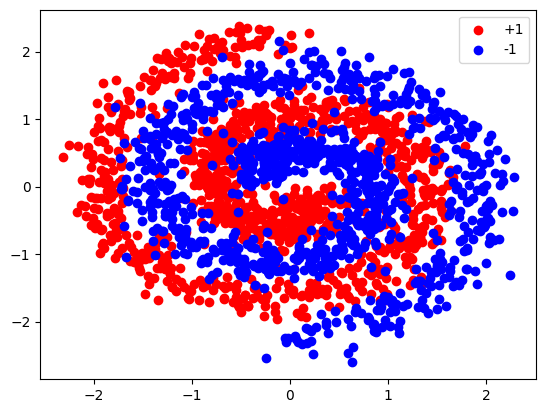

In [5]:
plt.scatter(Xs[ys == 1, 0], Xs[ys == 1, 1], c='r')
plt.scatter(Xs[ys != 1, 0], Xs[ys != 1, 1], c='b')
plt.legend(["+1","-1"])
plt.show()

In [6]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(Xs, ys, test_size=0.20)

In [7]:
train_dataset = GenericDataset(Xtrain, Ytrain)
test_dataset = GenericDataset(Xtest, Ytest)

In [8]:
def train_epoch(model, opt, criterion, batch_size=64):
    model.train()
    losses = []
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        opt.zero_grad()
        y_hat = model(x_batch)
        loss = criterion(y_hat.flatten(), y_batch)
        loss.backward()
        opt.step()
        losses.append(loss.cpu().data.numpy())
    return np.mean(losses)

In [9]:
# Define model parameters
input_size = 4
output_size = 1
hidden_size = 4
shuffle = True

# Define training parameters
epochs = 100
lr = 0.01
batch_size = 64

# Device parameters
device = "cuda"

In [10]:
# Declare TwoNet
model=TwoNetBC(input_size, output_size, hidden_size)
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))
#optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
criterion = nn.BCELoss()
train_loader=DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=shuffle)

In [11]:
# Train model
model.to(device)
e_losses = []

for epoch in range(epochs):
    e_losses.append((train_epoch(model, optimizer, criterion, batch_size)))


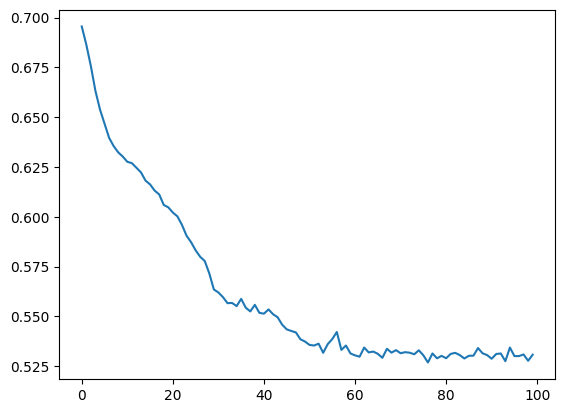

In [12]:
# Plot loss
plt.plot(e_losses)

In [13]:
# Evaluate model on test data
model.eval()
test_loader = DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=shuffle)

preds = []
labels = []
    
for batch_vec, batch_labels in iter(test_loader):
    batch_vec = batch_vec.to(device)
    
    batch_outputs = model(batch_vec)
    batch_preds = batch_outputs.cpu().detach().numpy()
    batch_labels = batch_labels.numpy()
    preds.append(batch_preds)
    labels.append(batch_labels)

preds = np.concatenate(preds)
labels = np.concatenate(labels)

In [14]:
# Compute model accuracy
diff = (preds.round().flatten() == labels)
acc = diff.sum() / diff.size
acc

0.745